# Why do we need a graphics processing unit (GPU)?

When we adopt big neural networks trained on large datasets, using GPUs speeds up training (and inference) significantly.




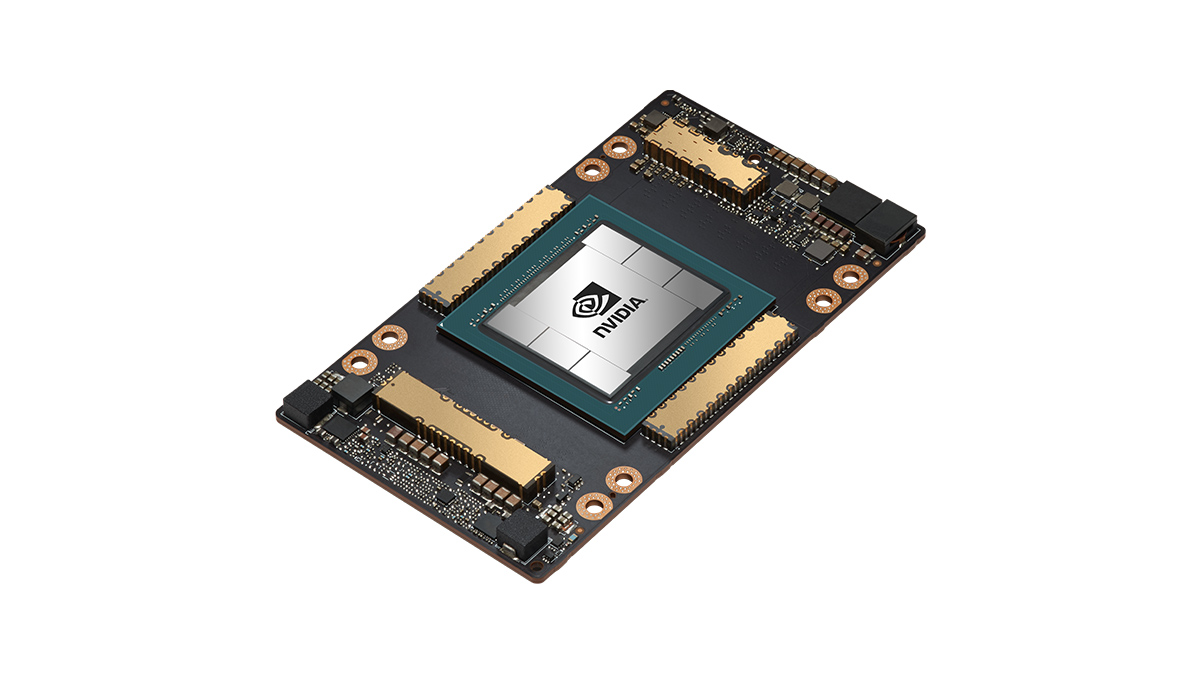

GPUs are specialized processors originally designed to accelerate graphics rendering. They can perform multiple, simultaneous computations. This makes them suitable for training machine learning models whose computations can be parallelized. Neural networks belong to this category (think to linear transformations or convolutions).

More specifically, GPUs are composed of thousands of parallel processing units called cores. Each core handles a separate part of the same task. A GPU also has its own RAM (random access memory) to store data or intermediate computations.

The dominant player in the market of GPUs for high-performance computing is NVIDIA. Their current best GPU is the [NVIDIA H100](https://resources.nvidia.com/en-us-tensor-core/nvidia-tensor-core-gpu-datasheet). This GPU can process 
up to 51 trillion floating point operations per second! Unfortunately, modern GPUs are extremely expensive.

To make programming GPU-based code easier, NVIDIA developed CUDA. CUDA is a programming model similar to C++. It natively supports a bunch of operations extremely useful for deep learning.


In this tutorial, we will show you the importance of using GPUs in deep learning. 


**Important:** Please, switch Colab to a GPU-based machine. Go to Runtime, change runtime type, and select "GPU".

In [1]:
import torch
import matplotlib.pyplot as plt
from statistics import mean

Let's perform a linear transformation:

In [2]:
# Initializing a linear layer
m = torch.nn.Linear(5000, 5000)

# Random input
input = torch.randn(1000, 5000)

# First Run
output = m(input)

# Input for the second run
input = torch.randn(1000, 5000)

Now, we initialized everything and already ran the first linear transformation. Note that the first run can be slower than the others due to some initialization overhead. We thus compute the execution time on the second run:

In [3]:
%%time
output = m(input)

CPU times: user 1.04 s, sys: 40.4 ms, total: 1.08 s
Wall time: 1.85 s


Let's now see what happens on the GPU:

In [4]:
# Switch to GPU
m = m.to('cuda:0')
input = input.to('cuda:0')

# First run
output = m(input)

# Input for the second run
input = torch.randn(1000, 5000, device='cuda:0')

In [5]:
%%time
output = m(input)

CPU times: user 783 µs, sys: 926 µs, total: 1.71 ms
Wall time: 1.69 ms


As you can see, there is an important speed-up when using a GPU!

Let's now see what happens when progressively increasing the number of neurons.
To do it, let's first define a bunch of functions that measure the execution time:

In [6]:
import timeit

def get_duration(neurons, batch_size=1000, device='cpu'):
  "Measure the duration (in ms) of a linear transformation."
  m = torch.nn.Linear(neurons, neurons, device=device)
  input = torch.randn(batch_size, neurons, device=device)
  output = m(input)

  input = torch.randn(batch_size, neurons, device=device)
  starttime = timeit.default_timer()
  output = m(input)
  duration = timeit.default_timer() - starttime
  return duration * 1000

def average_duration(N_avg=5, neurons=5000, batch_size=1000, device='cpu'):
  "Measure the averagge duration (in ms) of a linear transformation."
  durations = []
  for i in range(N_avg):
    duration = get_duration(neurons, batch_size=batch_size, device=device)
    durations.append(duration)
  return(mean(durations))

def get_durations_vs_neurons(device = 'cpu', min_neurons = 1000, 
                             max_neurons = 5000, neuron_step = 1000,
                             batch_size=1000, N_avg=5):
  """Measure the duration (in ms) of a linear transformation wrt the number of 
  neurons in the linear transformation."""
  durations = []
  range_neurons = range(min_neurons,max_neurons+1, neuron_step)
  for neurons in range_neurons:
    duration = average_duration(N_avg=N_avg, neurons=neurons, batch_size=batch_size, device=device)
    durations.append(duration)
  return durations, list(range_neurons)

Let's now run the experiment:

In [7]:
duration_cpu, neurons = get_durations_vs_neurons()
duration_gpu, neurons = get_durations_vs_neurons(device = 'cuda:0')

We can plot the durations vs the number of neurons:

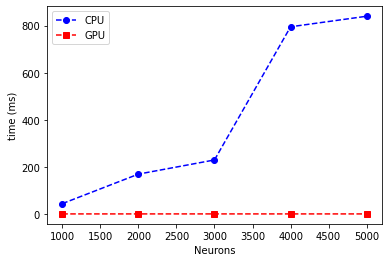

In [8]:
plt.plot(neurons, duration_cpu, "o--b", label="CPU")
plt.plot(neurons, duration_gpu, "s--r", label="GPU")

plt.ylabel('time (ms)')
plt.xlabel('Neurons')
plt.legend()
plt.show()

As you can see, the computation time observed with the CPU increases exponentially when adding more neurons. This is due to the sequential nature of the CPU. The GPU, instead, parallelizes all the computations and the execution time does not depend strongly on the number of neurons (at least until there is memory available).

But what happens with a tiny neural network? Let's take a look!

In [12]:
duration_cpu, neurons = get_durations_vs_neurons(min_neurons = 1, max_neurons = 500, neuron_step = 10, batch_size=1, N_avg=100)
duration_gpu, neurons = get_durations_vs_neurons(device = 'cuda:0', min_neurons = 1, max_neurons = 500, neuron_step = 10, batch_size=1, N_avg=100)

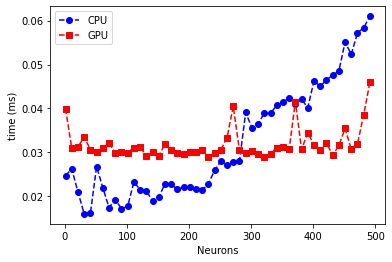

In [13]:
plt.plot(neurons, duration_cpu, "o--b", label="CPU")
plt.plot(neurons, duration_gpu, "s--r", label="GPU")

plt.ylabel('time (ms)')
plt.xlabel('Neurons')
plt.legend()
plt.show()

When the network is really small, the CPU is faster than the GPU. At this point you need to ask yourself: “*how many neurons do I need?*”. The answer to this is of course specific to the application and it needs to be tuned using your validation data set. Then you can decide whether you need to run on GPU or not.